In [ ]:
import sys
sys.path.append('C:\\Users\\szb37\\My Drive\\Projects\\Unmasking power\\UP codebase')
import src.config as config
import src.power as power
import pandas as pd
import numpy as np
from itertools import product
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 300  # Set display DPI
plt.style.use('seaborn-v0_8-notebook')  # notebook-optimized

n_trials=100
samples_perarm = np.arange(10, 110, 10).tolist()
samples_total = [2*armsample for armsample in samples_perarm]
max_sample = max(samples_total)

# CGR MoE vs sample size

In [12]:
### Generate CGR data
df_patientsData=[]
for cgr in np.arange(0.5, 1, 0.1):
    cgr = round(cgr, 2)
    df_patientsData.append(
        power.DataGeneration.get_df_patientsData(
            scenario = f'CGR {cgr}', 
            n_trials = n_trials, 
            sample = max_sample, 
            params = [{
                'type': 'binaryguess',
                'arm_params':{
                    'C': {'cgr': cgr,},
                    'T': {'cgr': cgr,},},}]))

df_patientsData = pd.concat(df_patientsData, ignore_index=True)
df_patientsData = df_patientsData.rename(columns={'value': 'cgr',})    

# Calculate CIs
df_CIs = power.FreqStats.get_df_cgrCIs_vector(
    df_patientsData = df_patientsData, 
    samples = samples_total,) 
df_CIs = power.FreqStats.add_sigdiff(df_CIs)
df_CIs.head(3)

,scenario,trial,sample,cgr,cgr_ciL,cgr_ciH,cgr_moe,cgr_sigdiff
0,CGR 0.5,0,20,0.550,0.315,0.769,0.227,False
1,CGR 0.5,0,40,0.450,0.293,0.615,0.161,False
2,CGR 0.5,0,60,0.467,0.337,0.600,0.132,False


In [13]:
### Calculate avg across trials
rows = []
scenarios = df_CIs.scenario.unique()
samples = df_CIs['sample'].unique()

for scenario, sample in product(scenarios, samples):

    df_tmp = df_CIs.loc[
        (df_CIs.scenario==scenario) & 
        (df_CIs['sample']==sample)]

    rows.append({
        'scenario': scenario,
        'sample_total': sample, 
        'cgr': df_tmp.cgr.mean(),
        'cgr_ciL': df_tmp.cgr_ciL.mean(),
        'cgr_ciH': df_tmp.cgr_ciH.mean(),
        'cgr_moe': df_tmp.cgr_moe.mean(),})    

df_mean_CIs = pd.DataFrame(rows)
df_mean_CIs.head(3)

,scenario,sample_total,cgr,cgr_ciL,cgr_ciH,cgr_moe
0,CGR 0.5,20,0.52700,0.30040,0.74517,0.22238
1,CGR 0.5,40,0.51225,0.35112,0.67150,0.16007
2,CGR 0.5,60,0.50613,0.37485,0.63681,0.13102


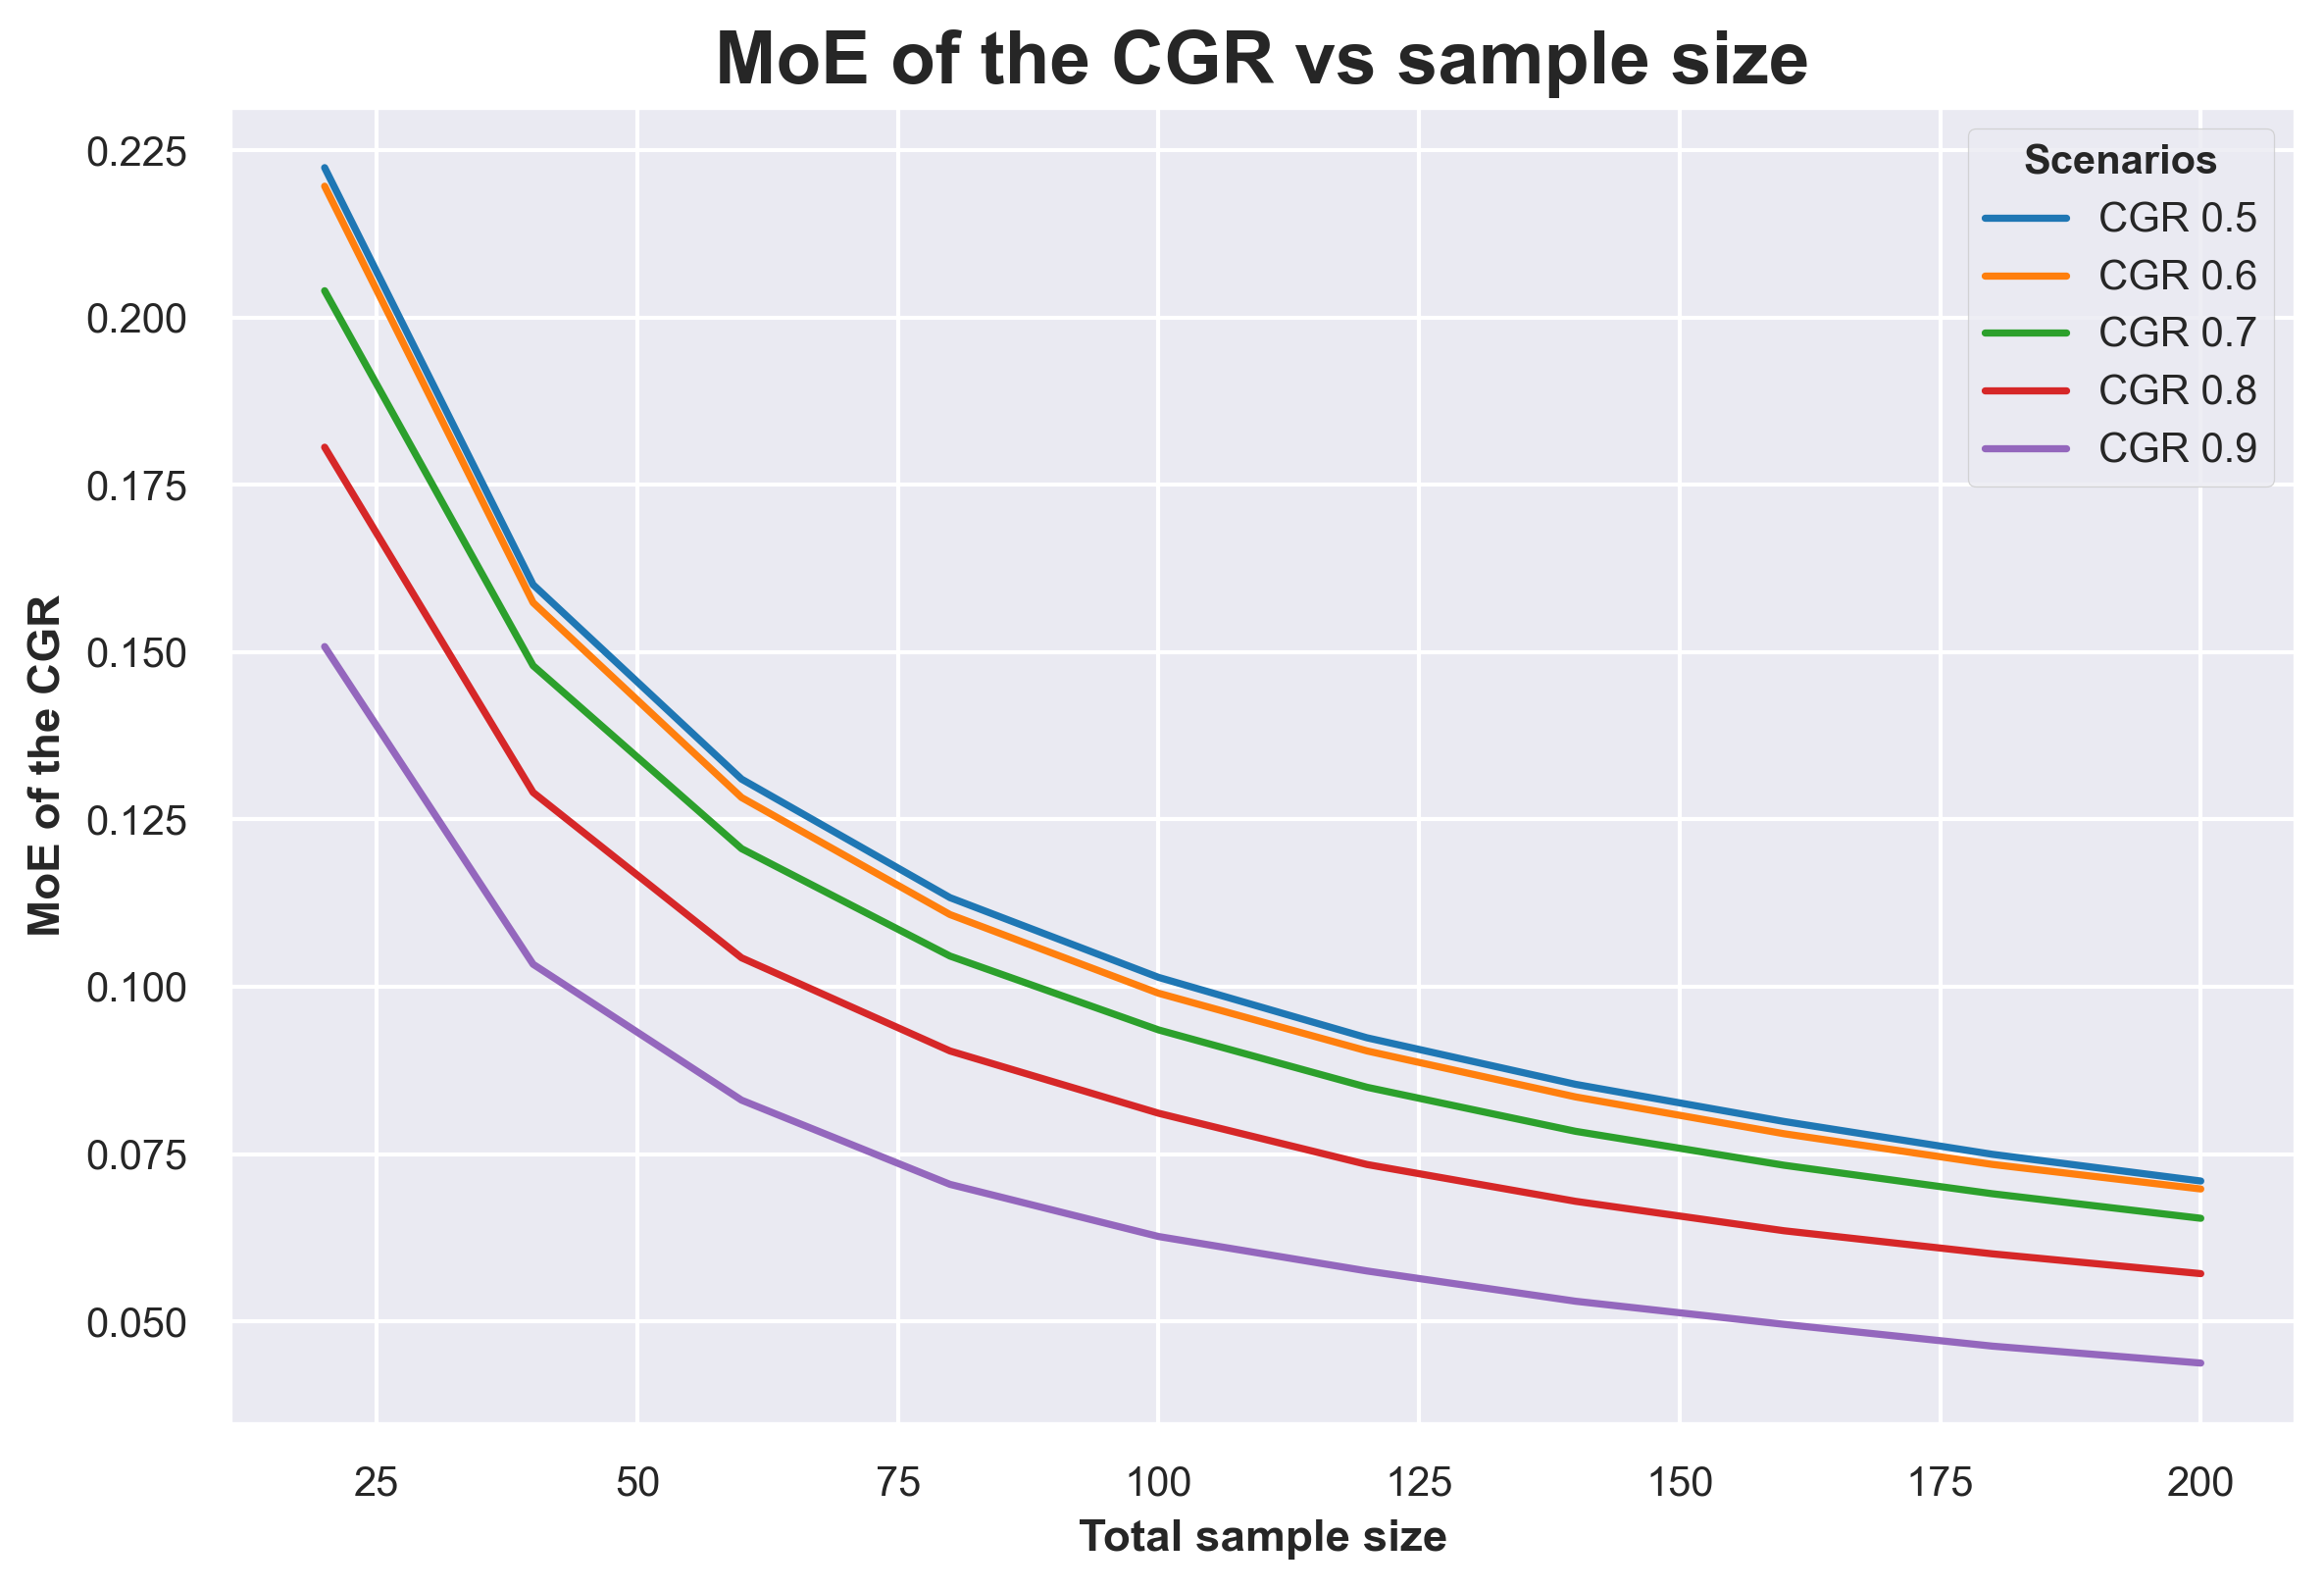

In [14]:
### Plot results
fig, ax = plt.subplots()
sns.lineplot(
    data = df_mean_CIs,
    x = 'sample_total', 
    y = 'cgr_moe',
    hue = 'scenario',
)

plt.title('MoE of the CGR vs sample size',  fontweight='bold', fontsize=18)
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('MoE of the CGR', fontweight='bold')
ax.tick_params(axis='both')
plt.tight_layout()
plt.legend(
    title='Scenarios', 
    title_fontproperties = {'weight': 'bold'},)
power.Helpers.save_fig(fig, 'cgrMoE_vs_sample')
plt.show()

# GMG MoE vs sample size

In [ ]:
### Generate GMG mock data & calc CIs, significance
df_patientsData = []

### Keep SD constant, vary Δguess
# sd = 7.6 # This the average SD in POP data
# for diff in np.arange(0, 6, 1.5):
#     diff = round(diff, 1)
#     df_patientsData.append(
#         power.DataGeneration.get_df_patientsData(
#             scenario = f'Δ guess {diff}mg', 
#             n_trials = n_trials, 
#             sample = sample, 
#             params = [{
#                 'type': 'normal',
#                 'arm_params':{
#                     'C': {'mean':      10, 'sd': sd,},
#                     'T': {'mean': 10+diff, 'sd': sd,},},}]))
# df_patientsData = pd.concat(df_patientsData, ignore_index=True)
# df_patientsData = df_patientsData.rename(columns={'value': 'gmg',})    

### Keep Δguess constant, vary SD
for sd in np.arange(2, 11, 2):
    sd = round(sd, 1)
    df_patientsData.append(
        power.DataGeneration.get_df_patientsData(
            scenario = f'Δguess 0mg; SD {sd}mg', 
            n_trials = n_trials, 
            sample = max_sample, 
            params = [{
                'type': 'normal',
                'arm_params':{
                    'C': {'mean': 10, 'sd': sd,},
                    'T': {'mean': 10, 'sd': sd,},},}]))
df_patientsData = pd.concat(df_patientsData, ignore_index=True)
df_patientsData = df_patientsData.rename(columns={'value': 'gmg',})    
df_patientsData.head(3)

,scenario,trial,trt,pID,gmg
0,Δguess 0mg; SD 2mg,0,C,0,7.059
1,Δguess 0mg; SD 2mg,0,C,1,6.980
2,Δguess 0mg; SD 2mg,0,T,2,19.307


In [21]:
### Calculate df_rawCIs, ie. CI of each arm
scenarios = df_patientsData.scenario.unique().tolist()
trials = df_patientsData.trial.unique().tolist()
trts = df_patientsData.trt.unique().tolist()

rows=[]
for scenario, sample_perarm, trial, trt in product(scenarios, samples_perarm, trials, trts):

    df_tmp = df_patientsData.loc[
        (df_patientsData.scenario==scenario) & 
        (df_patientsData.trial==trial) & 
        (df_patientsData.trt==trt)].iloc[:sample_perarm,:]

    gmg = df_tmp['gmg'].to_numpy()

    assert df_tmp.shape[0] == sample_perarm
    assert len(gmg) == sample_perarm

    ci = stats.ttest_1samp(gmg, popmean=0).confidence_interval(confidence_level=0.95)

    row={}
    row['scenario'] = scenario
    row['trial'] = trial
    row['trt'] = trt
    row['sample_perarm'] = sample_perarm
    row['gmg'] = round(gmg.mean(),2)
    row['ciL'] = round(ci.low,2)
    row['ciH'] = round(ci.high,2)
    row['moe'] = round((ci.high-ci.low)/2,2)
    rows.append(row)

df_rawCIs = pd.DataFrame(rows)
df_rawCIs.head(3)

,scenario,trial,trt,sample_perarm,gmg,ciL,ciH,moe
0,Δguess 0mg; SD 2mg,0,C,10,9.56,8.14,10.98,1.42
1,Δguess 0mg; SD 2mg,0,T,10,20.20,19.18,21.22,1.02
2,Δguess 0mg; SD 2mg,1,C,10,9.91,7.85,11.97,2.06


In [22]:
### Calculate CI of between-arms-difference
df_diffs = []
for scenario, sample_perarm, trial in product(scenarios, samples_perarm, trials):
    
    df_tmp = df_rawCIs.loc[
        (df_rawCIs.scenario==scenario) & 
        (df_rawCIs.sample_perarm==sample_perarm) & 
        (df_rawCIs.trial==trial)]
    
    assert df_tmp.shape[0] == 2
    assert len(df_tmp.trt.unique()) == 2

    df_diff = power.FreqStats.get_df_differenceCI(df_tmp, col_n='sample_perarm',)
    df_diff['sample_total'] = int(df_tmp.sample_perarm.sum())
    df_diffs.append(df_diff)

df_diffs = pd.concat(df_diffs)
df_diffs.head(3)

,scenario,trial,value,ciL,ciH,moe,sample_total
0,Δguess 0mg; SD 2mg,0,10.64,9.02,12.26,1.62,20
0,Δguess 0mg; SD 2mg,1,9.36,7.19,11.54,2.18,20
0,Δguess 0mg; SD 2mg,2,10.70,8.67,12.73,2.03,20


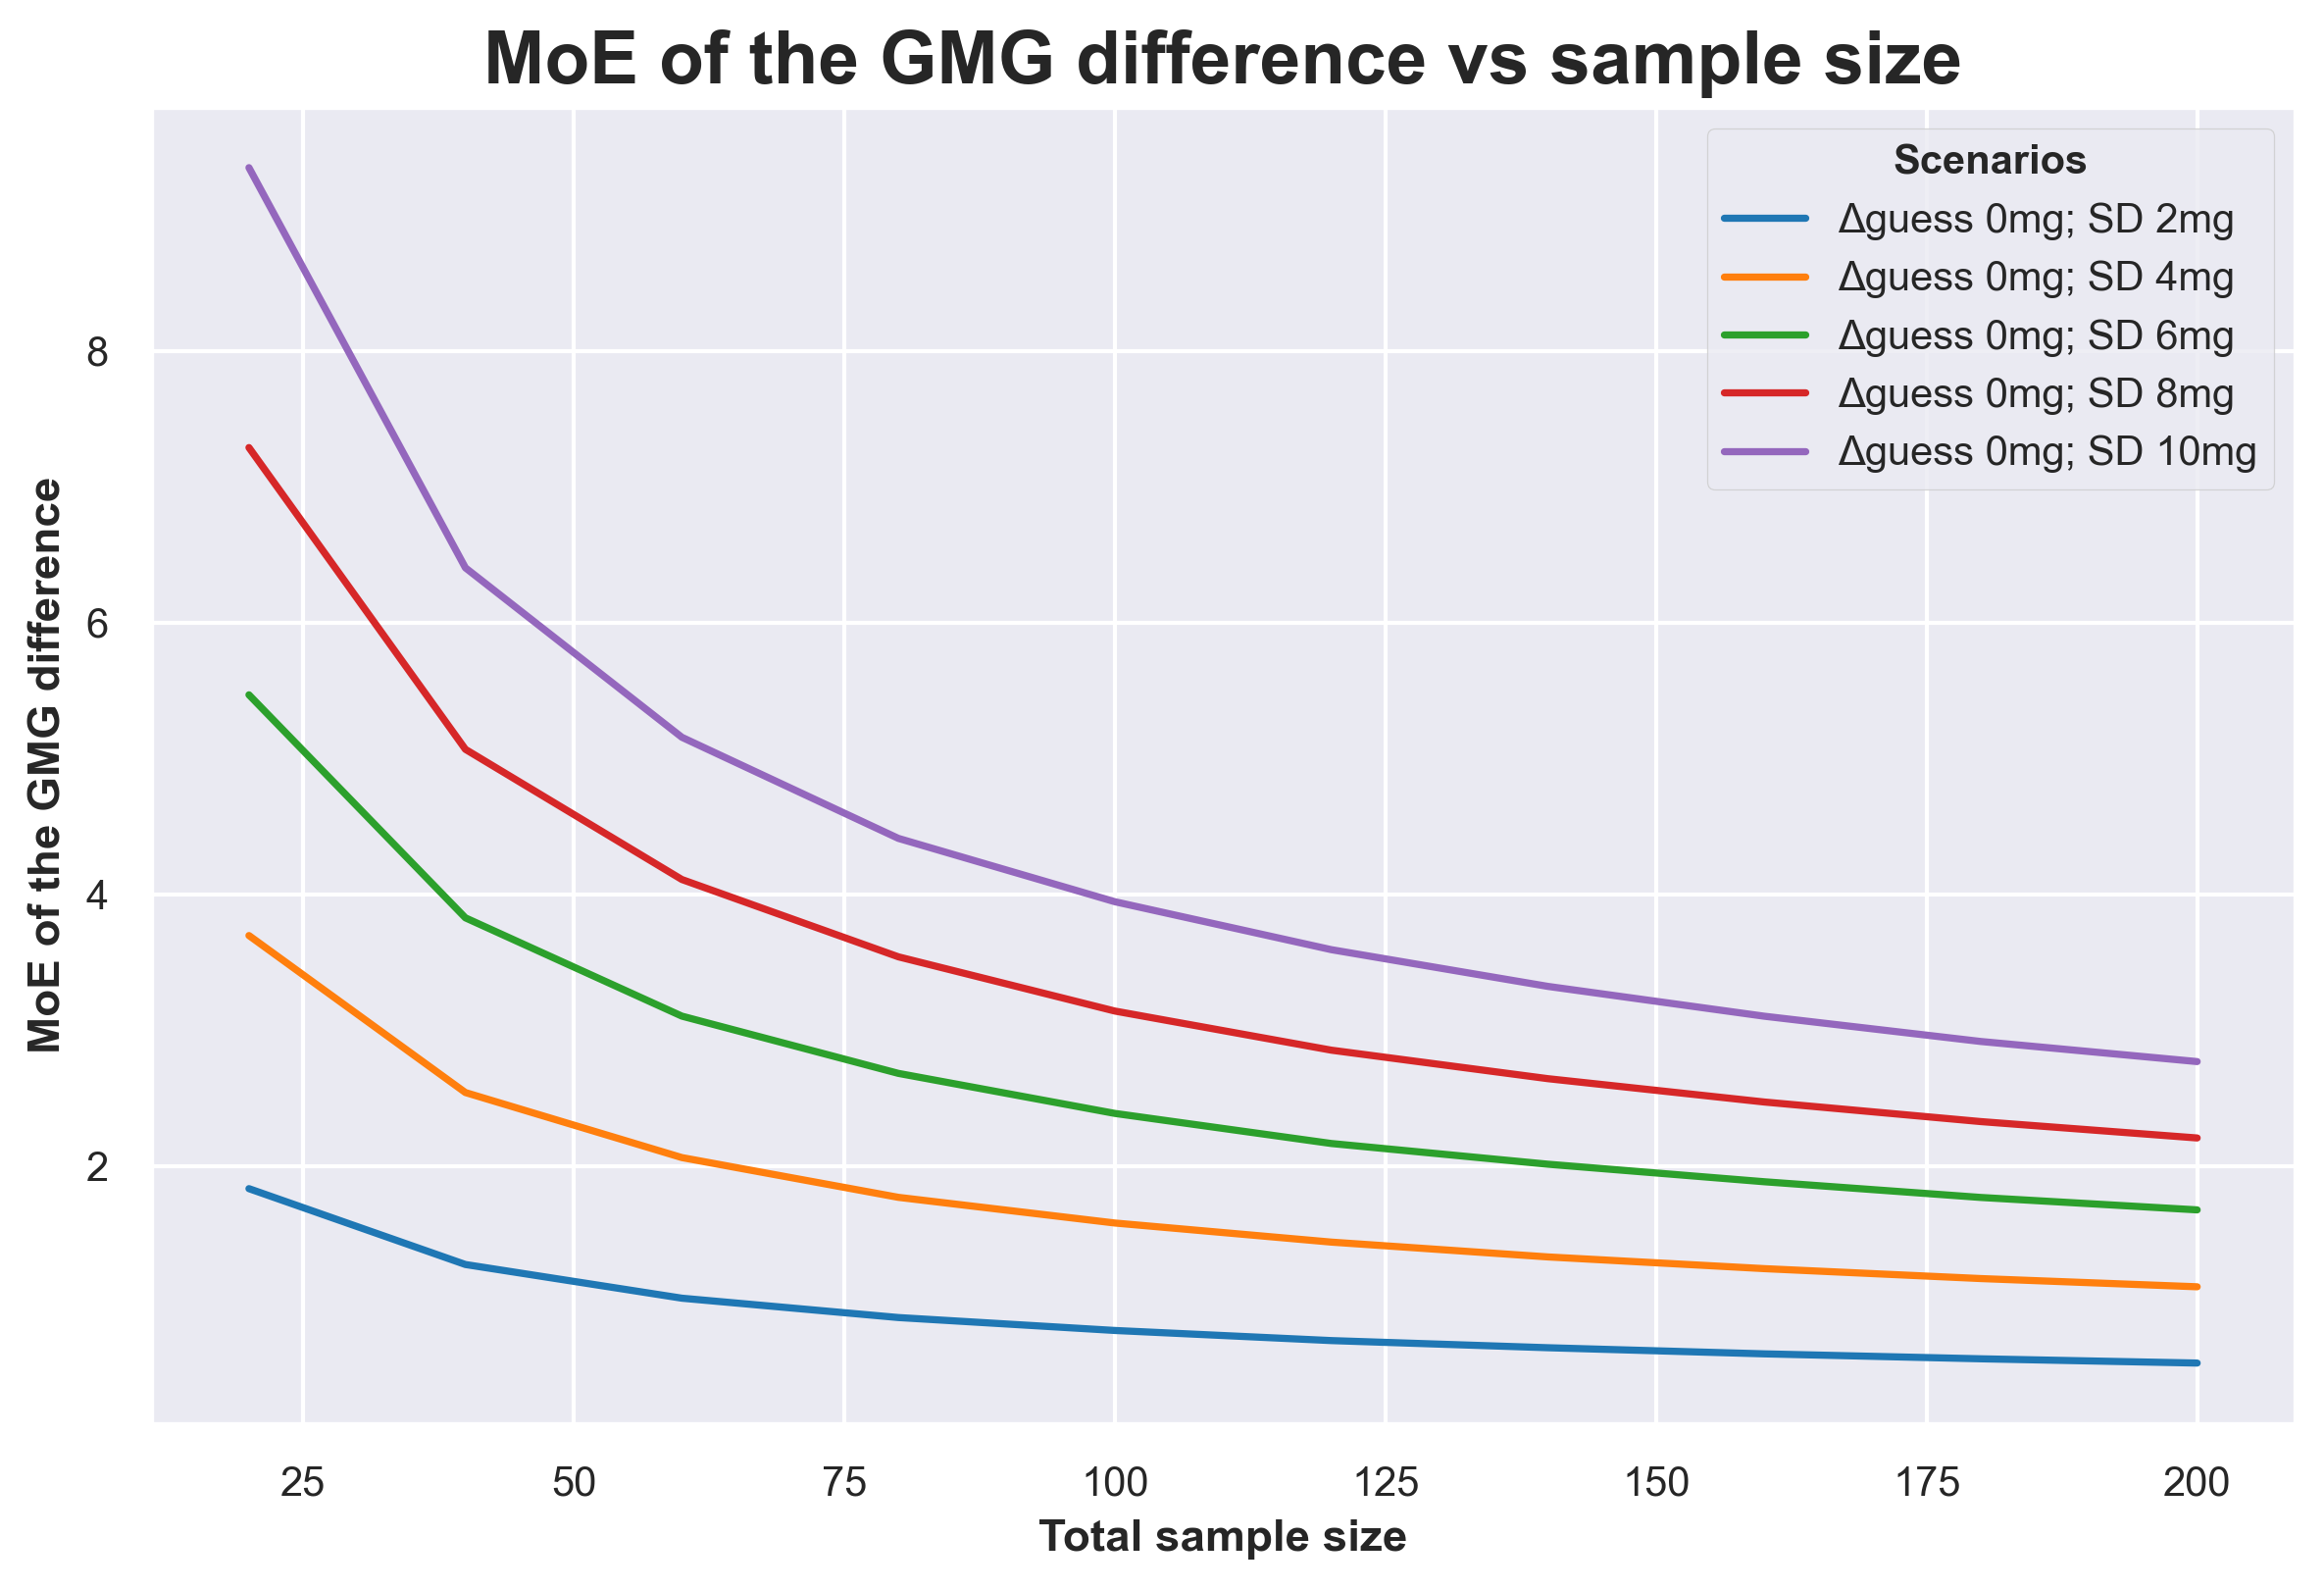

In [23]:
### Plot results
fig, ax = plt.subplots()
sns.lineplot(
    data = df_diffs,
    x = 'sample_total', 
    y = 'moe',
    errorbar = None,
    hue = 'scenario',
)

plt.title('MoE of the GMG difference vs sample size',  fontweight='bold', fontsize=18)
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('MoE of the GMG difference', fontweight='bold')
ax.tick_params(axis='both')
plt.tight_layout()
plt.legend(
    title='Scenarios', 
    title_fontproperties = {'weight': 'bold'},)

power.Helpers.save_fig(fig, 'gmgMoE_vs_sample')
plt.show()